### 6. Loading and application of one model for YOLO and one for semantic segmentation

In [1]:
from PIL import Image
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torchvision.transforms as transforms

In [2]:
%matplotlib inline

In [ ]:
#load the yolo-model from the pytorch hub
yolo_model = torch.hub.load('ultralytics/yolov5', 'custom', path='../models/yolov5s.pt')

Using cache found in C:\Users\alexa/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-11-17 Python-3.11.1 torch-2.4.1+cpu CPU

100%|██████████| 14.1M/14.1M [00:01<00:00, 11.0MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [ ]:
#get some test images 
imgs = ['https://ultralytics.com/images/zidane.jpg','https://ultralytics.com/images/bus.jpg', '../data/example.jpg']  

In [ ]:
#predict the test images
results = yolo_model(imgs)

C:\Users\alexa/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


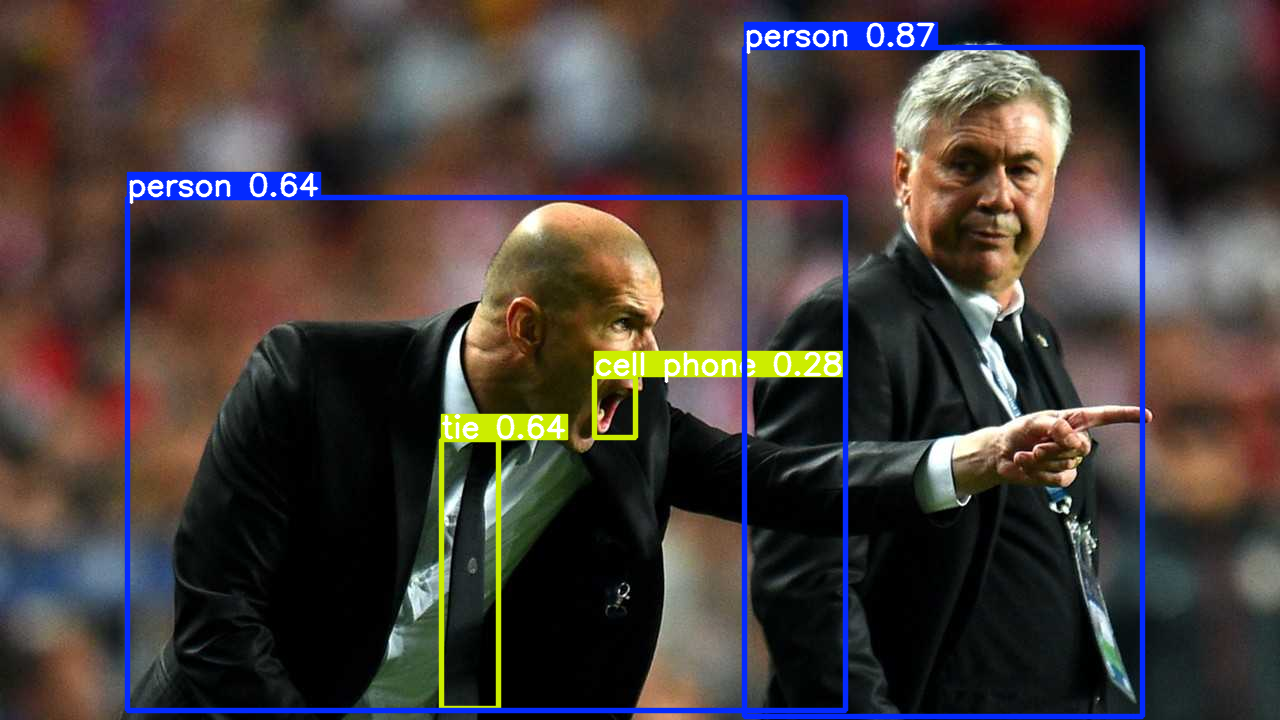

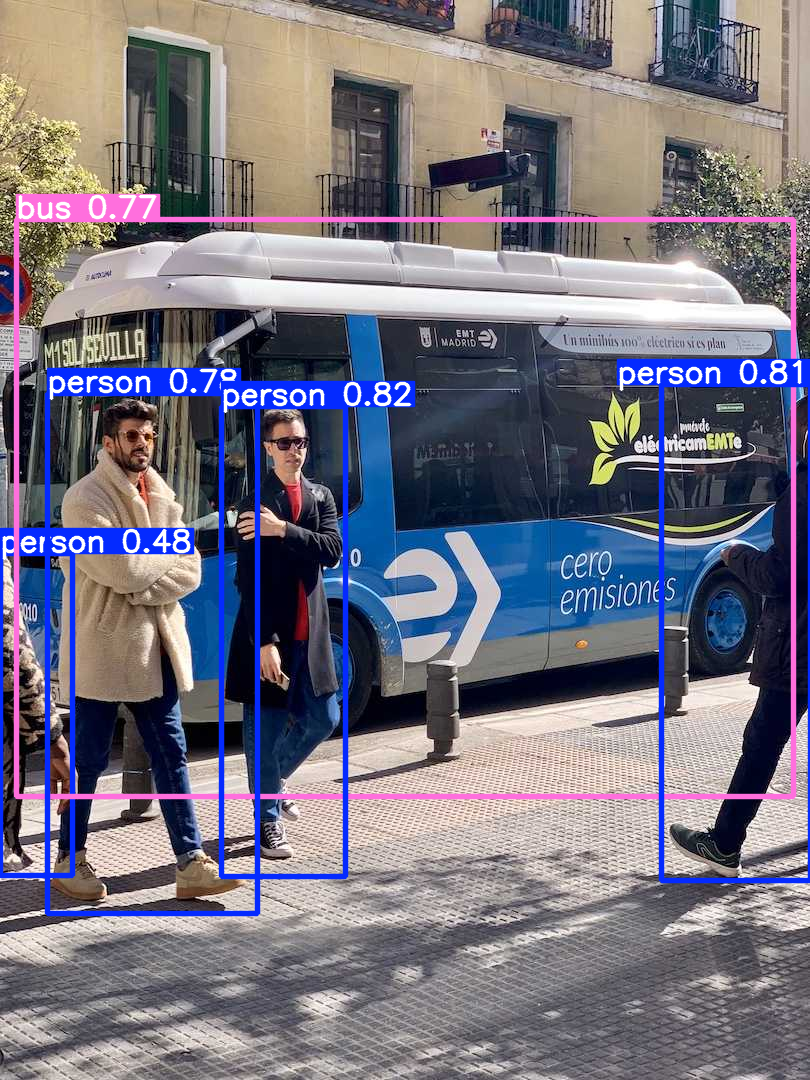

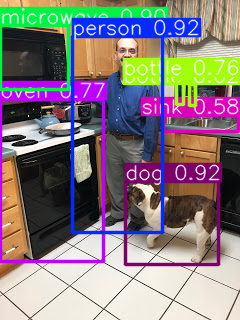

In [ ]:
#show the results
results.show()

In [ ]:
#load the segmentation model from pytorch hub
segmentation_model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)

Using cache found in C:\Users\alexa/.cache\torch\hub\pytorch_vision_v0.10.0


In [ ]:
#transfrom the images so they have the right input size (the have to be at least 224x224)
preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),  # Resize to ensure smallest dimension is 224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
#preprocess the images
image_paths = ['../data/deeplab1.png','../data/segmentation_input_1.jpg', '../data/segmentation_input_2.jpg']
preprocessed_images = []

for image_path in image_paths:
    image = Image.open(image_path).convert("RGB")  # Load image and ensure RGB format
    preprocessed_image = preprocess(image).unsqueeze(0)  # Apply preprocessing
    preprocessed_images.append(preprocessed_image)

    print(preprocessed_image.shape)



torch.Size([1, 3, 224, 279])
torch.Size([1, 3, 224, 330])
torch.Size([1, 3, 224, 291])


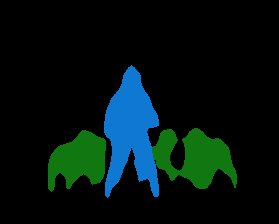

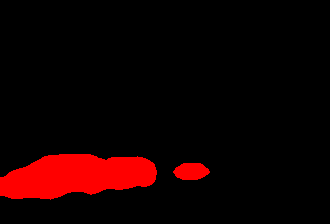

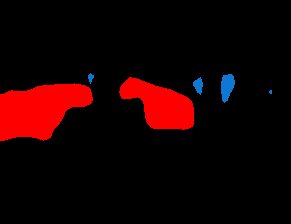

In [ ]:
#predict the classes on the image
segmentation_model.eval()

to_pil = transforms.ToPILImage()

palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
num_classes = 21
colors = torch.as_tensor([i for i in range(num_classes)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

colors[7] = [255, 0, 0]   # Car: red

with torch.no_grad():
    for preprocessed_image in preprocessed_images:
        output = segmentation_model(preprocessed_image)['out'][0]
        
        output_predictions  = output.argmax(0)

        r = Image.fromarray(output_predictions.byte().cpu().numpy())
        r.putpalette(colors.flatten())

        # Display the image
        display(r)